## Calculate and plot the percentage of missing metrics for each California census tract
* Process all Cal-CRAI metrics and merge into one dataframe
* Calculate total percentage of missing (nan) data for each metric
* Bin the percentages
* Plot

Note: There are multiple considerations to be made regarding which census tracts to use, along with which metrics/indicators to consider for these specific tract types (low/no population, water body, millitary installations). The Cal-CRAI team is putting a pin in this notebook and its resulting plot with the intention to iterate and improve for Cal-CRAI Version 2.

In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict
import numpy as np

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, delete_items
from scripts.utils.cal_crai_calculations import process_domain_csv_files, calculate_missing_percentage_and_columns
from scripts.utils.cal_crai_plotting import missing_metrics_plot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # Show full column width

## Pull all data from AWS index data bucket

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


## Isolate for metric files only, then run the processing function to merge into a single file

In [3]:
# when domain prefix is left, the function processes all metrics together
domain_prefix = ''
input_folder = r'aws_csvs'
output_folder = "all_metrics_folder"
meta_csv = r'../utils/calcrai_metrics.csv'

merged_output_file = f'concatenate_{domain_prefix}metrics.csv'
metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 110 CSV files within the '' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN.
Processed CSV saved as concatenate_metrics.csv


## Open the processed csv file and drop the island tract row

In [4]:
# Load the data
cal_crai_metrics_merged = pd.read_csv('concatenate_metrics.csv')

# Specify the GEOIDs to exclude
excluded_geoids = ['6075980401', '06075980401']

# Drop rows with the specified GEOIDs
cal_crai_metrics_merged = cal_crai_metrics_merged[~cal_crai_metrics_merged['GEOID'].astype(str).isin(excluded_geoids)]

# Check the first few rows after dropping
cal_crai_metrics_merged

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,paging_towers_data_count,power_plant_count,avg_num_psps_event,radio_towers_data_count,number_of_airports,number_of_bottlenecks,numbers_of_bridges,highway_length_in_miles,railway_length_in_miles,tv_contour_data_count,num_exclusive_wastewater_facilities,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days,nfip_participation,total_emergency_management_funding,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_firefighting_and_prevention_workers_employed_per_10000,num_fire_stations_per_10000_people,num_flood_policies,total_hazard_mitigation_funding,housing_units_with_mortgage,percent_prepared_for_general_disaster,percent_prepared_without_power,percent_prepared_without_water,num_police_officers_employed_per_10000,num_registered_nurses_employed_per_10000,percent_under_timber_management,percent_sampled_wells_contaminated,percent_unhealthy_air_quality,protected_areas_percentage,esi_mean,ssma_mean,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire,SpBioWtEco,tract_percent_impervious,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,12.0,0.0,0.800000,19.0,3.0,5.0,302.0,920.838160,181.100468,13.0,16.0,37.984370,197.583333,7394.25,3.500000,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225000,769.522222,14348.571429,74.250000,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.000000,4.0,0.0,3.5,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.130130,NaN,NaN,3.664105,17.313634,-0.153958,-0.150978,85.7,94.2,86.1,0.788310,10.386114,4.680330,0.0,0.0420

## Run the same Sea Level Risk mask for the index calculation
* inland areas will be giving nan entries for all SLR metrics

In [5]:
slr_mask_data = '../utils/slr_mask_layer.csv'
slr_mask = pd.read_csv(slr_mask_data)
slr_mask = slr_mask.drop(columns={'county', 'geometry', 'COUNTYFP'})
slr_mask.head()

cal_crai_metrics_merged['GEOID'] = cal_crai_metrics_merged['GEOID'].astype(str)
slr_mask['GEOID'] = slr_mask['GEOID'].astype(str)

cal_crai_metrics_merged_cleaned = pd.merge(cal_crai_metrics_merged, slr_mask, on='GEOID', how='left')
cal_crai_metrics_merged_cleaned

cal_crai_metrics_merged_cleaned.loc[cal_crai_metrics_merged_cleaned['slr_impacted'] == 0, 'sea_level_rise_hazard_score'] = np.nan
cal_crai_metrics_merged_cleaned = cal_crai_metrics_merged_cleaned.drop(columns='slr_impacted')
cal_crai_metrics_merged_cleaned.head()

,GEOID,low_internet_download_flag,cellular_towers_data_count,percent_underground_transmission_lines,percent_housing_before_1980,percent_mobile_homes,percent_without_kitchen_facilities_or_plumbing,estimated_total_vacant_housing_units,microwave_towers_data_count,mobile_towers_data_count,paging_towers_data_count,power_plant_count,avg_num_psps_event,radio_towers_data_count,number_of_airports,number_of_bottlenecks,numbers_of_bridges,highway_length_in_miles,railway_length_in_miles,tv_contour_data_count,num_exclusive_wastewater_facilities,drought_coverage_percentage,drought_crop_loss_acres,drought_crop_loss_indemnity_amount,change_in_drought_years,percent_weeks_drought,mean_change_annual_heat_days,mean_change_annual_warm_nights,floodplain_percentage,avg_flood_insurance_payout_per_claim,estimated_flood_crop_loss_cost,precip_99percentile,surface_runoff,total_flood_fatalities,median_flood_warning_days,mean_change_cold_days,heat_crop_loss_acres,heat_crop_loss_indemnity_amount,avg_age_adjust_heat_hospitalizations_per_10000,median_heat_warning_days,slr_vulnerable_building_content_cost,fire_stations_count_diff,hospitals_count_diff,police_stations_count_diff,schools_count_diff,building_exposed_slr_count,slr_vulnerability_delta_percentage_change,slr_vulnerable_wastewater_treatment_count,rcp_4.5__50th_percent_change,burn_area_m2,change_ffwi_days,average_damaged_destroyed_structures_wildfire,average_annual_fatalities_wildfire,median_red_flag_warning_days,nfip_participation,total_emergency_management_funding,num_emergency_medical_technicians_and_paramedics_employed_per_10000,num_firefighting_and_prevention_workers_employed_per_10000,num_fire_stations_per_10000_people,num_flood_policies,total_hazard_mitigation_funding,housing_units_with_mortgage,percent_prepared_for_general_disaster,percent_prepared_without_power,percent_prepared_without_water,num_police_officers_employed_per_10000,num_registered_nurses_employed_per_10000,percent_under_timber_management,percent_sampled_wells_contaminated,percent_unhealthy_air_quality,protected_areas_percentage,esi_mean,ssma_mean,percent_vulnerable_soils,percent_vulnerable_drought,percent_vulnerable_fire,SpBioWtEco,tract_percent_impervious,percent_population_ambulatory_disabilities,percent_total_pop_american_indian_alaska_native,blood and organ banks per 10000 people,percent_population_cognitive_disabilities,est_gini_index,hachman_index,est_median_income_dollars,percent_children_household_financial_assistance,percent_1miurban_10mirural,health and personal care stores per 10000 people,heavy and civil engineering construction per 10000 people,hospitals per 10000 people,avg_hpsscore_mental_shortage_metric,narcotic_support_per_10000,real_percent_total_pop_over_65,personal and household goods repair and maintenance per 10000 people,avg_hpsscore_primary_care_metric,specialty trade contractors per 10000 people,percent_total_pop_under_5,asthma_related_ed_visits_per_10000_people_2019,cardiovascular_disease_related_ed_visits_per_10000_people_2019,education_percent_2019,avg_percent_population_homeless,housing_burden_percent_2019,sum_imp_water_bodies,linguistic_isolation_percent_2019,low_birth_weight_percent_2019,Percent of households without air conditioning,Percent of population employed and aged > 16 working outdoors,poverty_percent_2019,unemployment_percent_2019,"Number of Violent Crimes per 10,000 Population",percent_population_without_health_insurance,sea_level_rise_hazard_score
0,6001400100,0.0,2.0,0.0,15.032680,2.0,0.0,119.0,734.0,28.0,12.0,0.0,0.8,19.0,3.0,5.0,302.0,920.83816,181.100468,13.0,16.0,37.98437,197.583333,7394.25,3.50,0.570255,2.683333,17.908333,NaN,5463.8925,0.0,0.817024,1.264492,1.0,3.0,-3.225,769.522222,14348.571429,74.25,2.0,650084.0,3.0,0.0,1.0,14.0,1315.0,NaN,4.0,-3.740648,NaN,0.0,4.0,0.0,3.5,1.0,3835219.0,6.220614,6.461024,0.552943,2642.0,1.935016e+08,68.7,52.380952,57.142857,57.142857,12.441227,82.13013,NaN,NaN,3.664105,17.313634,-0.153958,-0.150978,85.7,94.2,86.1,0.788310,10.386114,4.680330,0.0,0.

## Function to calculate percent missing metrics

In [6]:
missing_metric = calculate_missing_percentage_and_columns(cal_crai_metrics_merged_cleaned)

## Inspect the missing metric column

In [7]:
# Calculate IQR
q1 = missing_metric['missing_percentage'].quantile(0.25)  # First quartile (25th percentile)
q3 = missing_metric['missing_percentage'].quantile(0.75)  # Third quartile (75th percentile)
iqr = q3 - q1

# Print IQR
print("IQR:", iqr)

# Max value in the column
max_value = missing_metric['missing_percentage'].max()
print("Max Value:", max_value)
print("Mean:", missing_metric.missing_percentage.mean())

IQR: 5.4054054054054035
Max Value: 38.73873873873874
Mean: 12.860044531823672


## 9 census tracts have missing metrics above 30%
* all of which are less than 40%


In [8]:
large_values = missing_metric['missing_percentage'] > 30
large_value_rows = missing_metric[large_values]
print(len(large_value_rows))
large_value_rows.tail()

9


,GEOID,missing_percentage,missing_columns
4074,6051000101,32.432432,"[mobile_towers_data_count, paging_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, housing_units_with_mortgage, percent_prepared_for_general_disaster, percent_prepared_without_power, percent_prepared_without_water, percent_under_timber_management, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, blood and organ banks per 10000 people, heavy and civil engineering construction per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, unemployment_percent_2019, sea_level_rise_hazard_score]"
4076,6051000201,34.234234,"[mobile_towers_data_count, paging_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, avg_flood_insurance_payout_per_claim, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, housing_units_with_mortgage, percent_prepared_for_general_disaster, percent_prepared_without_power, percent_prepared_without_water, percent_under_timber_management, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, blood and organ banks per 10000 people, heavy and civil engineering construction per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019, unemployment_percent_2019, sea_level_rise_hazard_score]"
4077,6051000202,33.333333,"[mobile_towers_data_count, paging_towers_data_count, number_of_bottlenecks, railway_length_in_miles, drought_crop_loss_acres, drought_crop_loss_indemnity_amount, heat_crop_loss_acres, heat_crop_loss_indemnity_amount, avg_age_adjust_heat_hospitalizations_per_10000, slr_vulnerable_building_content_cost, fire_stations_count_diff, hospitals_count_diff, police_stations_count_diff, schools_count_diff, building_exposed_slr_count, slr_vulnerability_delta_percentage_change, slr_vulnerable_wastewater_treatment_count, rcp_4.5__50th_percent_change, housing_units_with_mortgage, percent_prepared_for_general_disaster, percent_prepared_without_power, percent_prepared_without_water, percent_under_timber_management, percent_vulnerable_soils, percent_vulnerable_drought, percent_vulnerable_fire, blood and organ banks per 10000 people, heavy and civil engineering construction per 10000 people, hospitals per 10000 people, avg_hpsscore_mental_shortage_metric, narcotic_support_per_10000, personal and household goods repair and maintenance per 10000 people, avg_hpsscore_primary_care_metric, asthma_related_ed_visits_per_10000_people_2019, cardiovascular_disease_related_ed_visits_per_10000_people_2019, unemployment_percent_2019, sea_level_rise_hazard_score]"
7298,6075990100,31.531532,"[percent_housing_before_1980, percent_without_kitchen_facilities_or_plumbing, number_of_airports, number_of_bottlenecks, drought_c

## Bin the data into 5 categorys based on inspected missing data column
* 0-5%
* 5-10%
* 10-20%
* 20-30%
* above 30%

In [9]:
# Binning based on actual column values
binned_missing_metric_df = missing_metric.copy()

# Define the columns to bin and the bin edges based on actual values
columns_to_bin = ['missing_percentage']
bin_edges = [0, 5, 10, 20, 30, 100]  # Define bin edges based on actual values

# Apply pd.cut to each specified column and print the bin edges
for column in columns_to_bin:
    binned_missing_metric_df[column + '_bin'], bin_edges = pd.cut(
        binned_missing_metric_df[column], 
        bins=bin_edges,  # Use actual values for binning
        right=False,  # Specify if the bins are inclusive on the right
        labels=['0-5', '5-10', '10-20', '20-30', '30+'],  # Custom labels for binning
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')
    
# Create a copy and chain the .replace() calls
binned_missing_metric_viz = binned_missing_metric_df.copy()
binned_missing_metric_viz['missing_percentage_bin'] = (
    binned_missing_metric_viz['missing_percentage_bin']
    .replace('0-5', '0-5%')
    .replace('5-10', '5-10%')
    .replace('10-20', '10-20%')
    .replace('20-30', '20-30%')
    .replace('30+', '30+%')
)

# Show the resulting DataFrame with the binned columns
binned_missing_metric_viz.head()

Bin edges for missing_percentage: [  0   5  10  20  30 100]


C:\Users\jesse\AppData\Local\Temp\ipykernel_5832\3385644091.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  binned_missing_metric_viz['missing_percentage_bin']


,GEOID,missing_percentage,missing_columns,missing_percentage_bin
0,6001400100,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
1,6001400200,9.009009,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, protected_areas_percentage, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
2,6001400300,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
3,6001400400,8.108108,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
4,6001400500,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%


## Further process the data so it plays nicely with plotting function
* adjust GEOID string length and datatype

In [10]:
# GEOID handling
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].apply(lambda x: '0' + str(x))
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

# Ensure all values in GEOID are strings
binned_missing_metric_viz['GEOID'] = binned_missing_metric_viz['GEOID'].astype(str)

# Display the dataframe
binned_missing_metric_viz.head()

,GEOID,missing_percentage,missing_columns,missing_percentage_bin
0,06001400100,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
1,06001400200,9.009009,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, protected_areas_percentage, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
2,06001400300,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
3,06001400400,8.108108,"[floodplain_percentage, avg_flood_insurance_payout_per_claim, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%
4,06001400500,7.207207,"[floodplain_percentage, slr_vulnerability_delta_percentage_change, burn_area_m2, percent_under_timber_management, percent_sampled_wells_contaminated, avg_hpsscore_mental_shortage_metric, avg_hpsscore_primary_care_metric, sea_level_rise_hazard_score]",5-10%


## Plot the missing metric columns

### Plot the missing percentage data as a coninuous scale, with the scale being adjustable

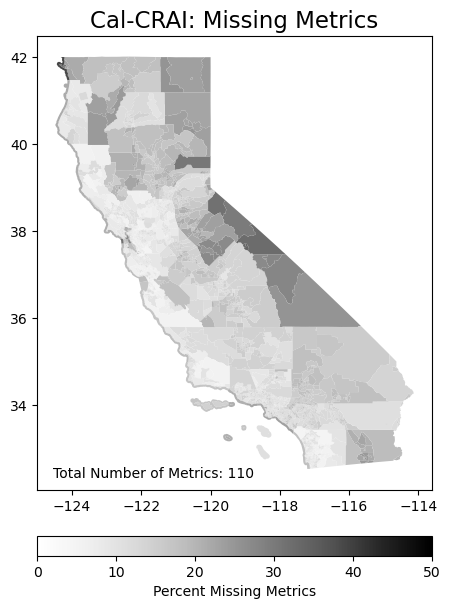

In [11]:
missing_metrics_plot(binned_missing_metric_viz, 
                     column='missing_percentage',
                     vmin=0, vmax=50,
                     plot_type='continuous', 
                     plot_title=True,
                     title='Cal-CRAI: Missing Metrics',
                     total_metrics=110)

## Plot the binned missing metric data outlined prior

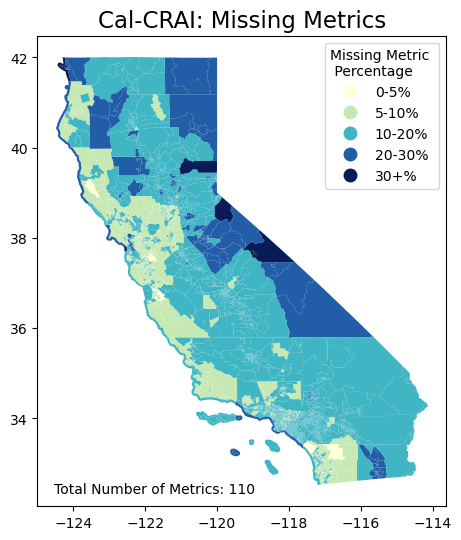

In [12]:
missing_metrics_plot(binned_missing_metric_viz,
                     'missing_percentage_bin',
                     save_name=f'Cal_CRAI_missing_metrics',
                     plot_title=True,
                     title='Cal-CRAI: Missing Metrics',
                     total_metrics=110)

## Similarly process and plot each individual domain
* have automated this so each domain is run, plotted, and saved

Processed and saved 20 CSV files within the 'built_' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN.
Processed CSV saved as built_folder/built_metrics.csv

Average missing metrics percentage: 2.396472392638037
Median missing metrics percentage: 0.0


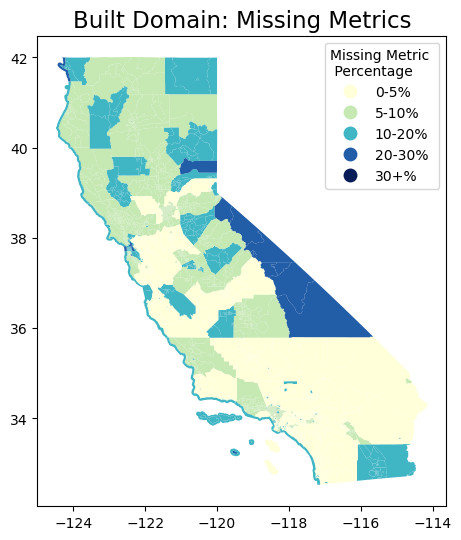

Processed and saved 33 CSV files within the 'society_' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN.
Processed CSV saved as society_folder/society_metrics.csv

Average missing metrics percentage: 8.561734788728653
Median missing metrics percentage: 6.0606060606060606


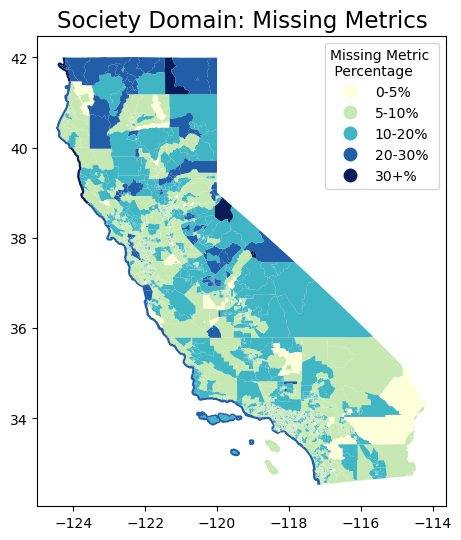

Processed and saved 15 CSV files within the 'governance_' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN.
Processed CSV saved as governance_folder/governance_metrics.csv

Average missing metrics percentage: 10.555068653228163
Median missing metrics percentage: 13.333333333333334


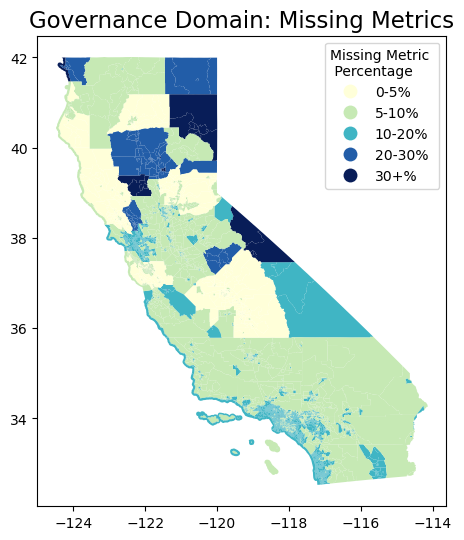

Processed and saved 9 CSV files within the 'natural_' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN.
Processed CSV saved as natural_folder/natural_metrics.csv

Average missing metrics percentage: 9.930372967182782
Median missing metrics percentage: 0.0


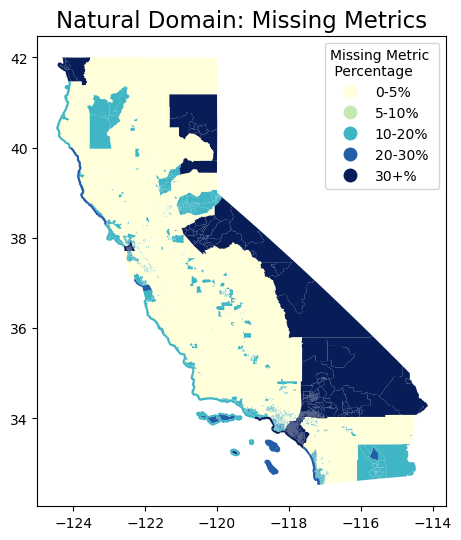

Processed and saved 33 CSV files within the 'climate_' domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN.
Processed CSV saved as climate_folder/climate_metrics.csv

Average missing metrics percentage: 22.706026080259207
Median missing metrics percentage: 21.21212121212121


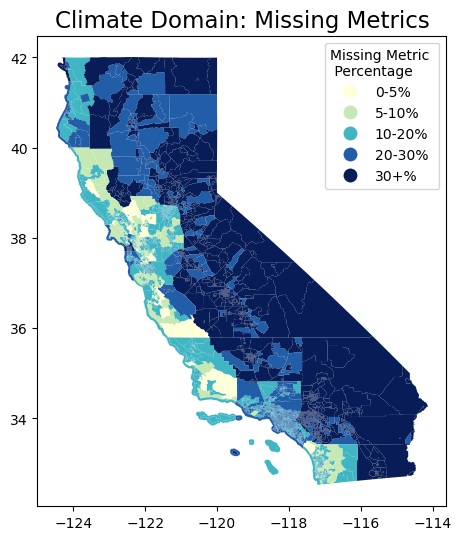

Processing and plotting completed for all domains.


In [13]:
# Define constants
DOMAIN_PREFIX = ['built_', 'society_', 'governance_', 'natural_', 'climate_']
INPUT_FOLDER = r'all_metrics_folder'
META_CSV = r'../utils/calcrai_metrics.csv'

BIN_EDGES = [0, 5, 10, 20, 30, 100]
BIN_LABELS = ['0-5%', '5-10%', '10-20%', '20-30%', '30+%']

# Utility functions
def clean_geoid_column(df, geoid_column='GEOID', excluded_geoids=None):
    """
    Cleans the GEOID column by adding leading zeros and removing trailing zeros/decimals.
    Optionally excludes specified GEOIDs from the DataFrame.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the GEOID column.
    geoid_column : str
        The name of the GEOID column.
    excluded_geoids : list, optional
        List of GEOIDs to exclude from the DataFrame.
    
    Returns:
    -------
    pd.DataFrame
        The cleaned DataFrame with specified GEOIDs excluded.
    """
    # Ensure the GEOID column exists
    if geoid_column in df.columns:
        # Clean the GEOID column
        df[geoid_column] = df[geoid_column].apply(lambda x: '0' + str(x))
        df[geoid_column] = df[geoid_column].astype(str).apply(
            lambda x: x.rstrip('0').rstrip('.') if '.' in x else x
        )
        df[geoid_column] = df[geoid_column].astype(str)  # Ensure string format

        # Drop rows with excluded GEOIDs, if specified
        if excluded_geoids:
            df = df[~df[geoid_column].isin(excluded_geoids)]
    
    return df

def bin_missing_metrics(df, column='missing_percentage'):
    """
    Bins the missing percentage column into predefined ranges.
    """
    df['missing_percentage_bin'] = pd.cut(
        df[column],
        bins=BIN_EDGES,
        labels=BIN_LABELS,
        right=False  # Inclusive on the left
    )
    df['missing_percentage_bin'] = pd.Categorical(
        df['missing_percentage_bin'],
        categories=BIN_LABELS,
        ordered=True
    )
    return df

# exclude island tract as it has very little data
excluded_geoids =['06075980401']


def process_and_plot_domain(prefix, input_folder, meta_csv):
    """
    Processes domain CSV files, calculates missing metrics, bins them, and plots results.
    """
    # Output directory for each domain to store results
    output_folder = f"{prefix}folder"
    os.makedirs(output_folder, exist_ok=True)
    output_file = f'{output_folder}/{prefix}metrics.csv'

    # Process and clean data
    metric_dict = process_domain_csv_files(prefix, input_folder, output_folder, meta_csv, output_file)
    df = pd.read_csv(output_file)
    df = clean_geoid_column(df, excluded_geoids=excluded_geoids)

    # Calculate missing metrics and bin results
    missing_metrics_df = calculate_missing_percentage_and_columns(df, geoid_column='GEOID')
    binned_df = bin_missing_metrics(missing_metrics_df)

    print('')
    print('Average missing metrics percentage:', missing_metrics_df.missing_percentage.mean())
    print('Median missing metrics percentage:', missing_metrics_df.missing_percentage.median())

    
    # Extract domain name and plot
    domain_name = prefix.rstrip('_').capitalize()
    missing_metrics_plot(
        binned_df,
        'missing_percentage_bin',
        save_name=f'{prefix}missing_metrics',
        plot_title=True,
        title=f"{domain_name} Domain: Missing Metrics"
    )
    return binned_df

# Main workflow for all domains
def main():
    all_results = []
    for prefix in DOMAIN_PREFIX:
        # Process and plot for each domain, and append the result to all_results
        result_df = process_and_plot_domain(prefix, INPUT_FOLDER, META_CSV)
        # Add the domain prefix as a column to distinguish the data
        result_df['domain'] = prefix.rstrip('_').capitalize()  # Add domain name as column
        all_results.append(result_df)

    # Concatenate all domain dataframes into one large dataframe
    combined_df = pd.concat(all_results, ignore_index=True)

    # Optionally, save the combined dataframe to CSV
    combined_df.to_csv('combined_missing_metrics.csv', index=False)

    print("Processing and plotting completed for all domains.")
    return combined_df

# Run the main workflow
combined_df = main()

## Delete desired folders, figs, and files

In [15]:
folders_to_delete = ['aws_csvs', 
                     'all_metrics_folder',
                     'built_folder', 
                     'climate_folder', 
                     'society_folder', 
                     'natural_folder', 
                     'governance_folder']

csv_files_to_delete = ["concatenate_metrics.csv", 'combined_missing_metrics.csv']
png_files_to_delete = ["Cal_CRAI_missing_metrics.png",
                       'climate_missing_metrics.png',
                       'governance_missing_metrics.png',
                       'built_missing_metrics.png',
                       'natural_missing_metrics.png',
                       'society_missing_metrics.png']
#zip_to_delete = ['.zip']
#gdb_to_delete = ['.gdb']

delete_items(folders_to_delete, csv_files_to_delete, png_files=png_files_to_delete) #, gdb_folders=gdb_to_delete, zip_files=zip_to_delete)

Folder does not exist: aws_csvs
Folder does not exist: all_metrics_folder
Folder does not exist: built_folder
Folder does not exist: climate_folder
Folder does not exist: society_folder
Folder does not exist: natural_folder
Folder does not exist: governance_folder
File does not exist: concatenate_metrics.csv
Deleted file: combined_missing_metrics.csv
PNG file does not exist: Cal_CRAI_missing_metrics.png
PNG file does not exist: climate_missing_metrics.png
PNG file does not exist: governance_missing_metrics.png
PNG file does not exist: built_missing_metrics.png
PNG file does not exist: natural_missing_metrics.png
PNG file does not exist: society_missing_metrics.png
